# core

In [1]:
"""
core.py
環境とエージェントの抽象クラス
"""
import numpy as np


class coreEnv:
    """ 環境の抽象クラス """
    def __init__(self):
        """ 初期処理 """
        # 引数の設定は適時編集
        self.n_act = 2  # <--- 行動数を設定
        self.done = False
        # ------------------------- 編集ここから
        # ------------------------- ここまで

    def reset(self):
        """ 状態を初期化 """
        self.done = False
        # ------------------------- 編集ここから
        obs = np.array([0, 0, 0, 0])  # ndarray
        # ------------------------- ここまで
        return obs

    def step(self, act):
        """ 状態を更新 """
        # 最終状態の次の状態はリセット
        if self.done is True:
            obs = self.reset()
            return None, None, obs
        # ------------------------- 編集ここから
        rwd = 1.0                   # float
        done = True                 # bool
        # ------------------------- ここまで
        self.done = done
        # ------------------------- 編集ここから
        # self.done を使った処理
        obs = np.array([0, 0, 0, 0])  # ndarray
        # ------------------------- ここまで
        return rwd, done, obs

    def render(self):
        """ 状態に対応した画像を作成 """
        # ------------------------- 編集ここから
        # img: 3d ndarray
        img = np.zeros((100, 200, 3), dtype=np.uint8)
        # ------------------------- ここまで
        return img


class coreAgt:
    """ エージェントの抽象クラス """
    def __init__(self):
        """ 初期処理 """
        # 引数の設定は適時編集
        self.epsilon = 0.4
        # ------------------------- 編集ここから
        # ------------------------- ここまで

    def select_action(self, obs):
        """ 観測に対して行動を出力 """
        # ------------------------- 編集ここから
        act = 0  # int
        # ------------------------- ここまで
        return act

    def learn(self, obs, act, rwd, done, next_obs):
        """ 学習 """
        if rwd is None:
            return
        # ------------------------- 編集ここから
        # ------------------------- ここまで

    def get_Q(self, obs):
        """ 観測に対するQ値を出力 """
        # ------------------------- 編集ここから
        Q = np.ndarray([0, 0])  # ndarray
        # ------------------------- ここまで
        return Q

    def save_weights(self, filepath):
        """ 方策のパラメータの保存 """
        # ------------------------- 編集ここから
        # ------------------------- ここまで

    def load_weights(self, filepath):
        """ 方策のパラメータの読み込み """
        # ------------------------- 編集ここから
        # ------------------------- ここまで


# env_myenv

In [2]:
# import cv2
import numpy as np
# import core
import mujoco
# from tqdm import trange

xml_path = './xml_models/micromouse.xml'
times = []
left_motor_kakusokudo = []
right_motor_kakusokudo = []
sensor_LF = []
sensor_LS = []
sensor_RF = []
sensor_RS = []



class MyEnv(coreEnv):

    def __init__(self): #引数で受け取るとかは特にないからこんな感じ　各インスタンス変数に値を入れていく
        self.n_act = 5
        self.done = False #最初だからFalse
        self.state = None #状態表示用変数
        self.m = mujoco.MjModel.from_xml_path(xml_path)#modelを読み込んで用意
        self.d = mujoco.MjData(self.m) #モデルのデータを用意

    def reset(self):
        """ 状態を初期化 """
        self.done = False
        # ------------------------- 編集ここから
        self.state = 'start'
        mujoco.mj_resetData(self.m, self.d)
        obs = np.array([0, 0, 0, 0])  # ndarray
        # ------------------------- ここまで
        return obs
    
    def step(self, act):
        """ 状態を更新 """
        # 最終状態の次の状態はリセット
        if self.done is True:
            obs = self.reset()
            return None, None, obs
        # ------------------------- 編集ここから
        self.d.ctrl = act
        mujoco.mj_step(self.m, self.d)
        mujoco.mj_kinematics(self.m, self.d)
        goal_pos = self.d.geom('goal').xpos
        mm_pos = self.d.geom('mein_body').xpos
        self.goal_range = np.sqrt((goal_pos[0] - mm_pos[0])**2+(goal_pos[1] - mm_pos[1])**2)

        rwd = -self.goal_range      # float  goalとの距離がそのまま罰になる
        done = False                 # bool

        if self.goal_range < 0.06: #ゴールに十分近かったら報酬を与えて，終了判定
            rwd = 300
            done = True

        # ------------------------- ここまで
        self.done = done
        # ------------------------- 編集ここから
        # self.done を使った処理
        ob1 = self.d.sensordata[0].copy() #sensor_LF
        ob2 = self.d.sensordata[1].copy() #sensor_LS
        ob3 = self.d.sensordata[2].copy() #sensor_RF
        ob4 = self.d.sensordata[3].copy() #sensor_RS
        obs = np.array([ob1, ob2, ob3, ob4])  # ndarray
        # ------------------------- ここまで
        return rwd, done, obs
    
    def render(self):
        """ 状態に対応した画像を作成 """
        # ------------------------- 編集ここから
        # img: 3d ndarray
        self.viewer.sync() # mj_stepで進めたシミュレーションを，描画に反映する　　物理状態の変更を反映する
        # ------------------------- ここまで
        return

# agt_TableQ

In [2]:
"""
agt_tableQ.py
Qテーブルを使ったQ学習アルゴリズム
"""
import sys
import pickle
import numpy as np

# 自作モジュール
import core


class TableQAgt(core.coreAgt):
    """ Qテーブルを使ったQ学習エージェントクラス """
    def __init__(           # 引数とデフォルト値の設定 (A)
            self,
            n_act=4,            # int: 行動の種類数
            init_val_Q=0,       # float: Q値の初期値
            epsilon=0.1,        # float: 乱雑度
            alpha=0.1,          # float: 学習率
            gamma=0.9,          # float: 割引率
            max_memory=10000,     # int: 記憶する最大の観測数
            filepath=None,      # str: 保存用ファイル名
            ):
        """ 初期処理 """
        # 引数の設定は適時編集
        self.epsilon = epsilon
        # ------------------------- 編集ここから
        self.n_act = n_act
        # エージェントのハイパーパラメータ (B)
        self.init_val_Q = init_val_Q
        self.gamma = gamma
        self.alpha = alpha

        # 保存ファイル名 (C)
        self.filepath = filepath

        # Qテーブル関連 (D)
        self.Q = {}     # Qテーブルの辞書を用意
        self.len_Q = 0  # Qテーブルに登録した観測の数記録変数　最初だから０
        self.max_memory = max_memory #記録する最大の観測数
        # ------------------------- ここまで

    def select_action(self, obs):
        """ 観測に対して行動を出力 """
        # ------------------------- 編集ここから
        # obsを文字列に変換 (A)　辞書でやってるから，ndarray型を変える必要があるので文字列に変換しといてる
        obs = str(obs)

        # obs が登録されていなかったら初期値を与えて登録 (B) #登録されていたら何もしない
        self._check_and_add_observation(obs)

        # 確率的に処理を分岐 (C)
        if np.random.rand() < self.epsilon:
            # epsilon の確率(D)
            act_select = np.random.randint(0, self.n_act)  # ランダム行動選択
        else:
            # 1-epsilon の確率(E)
            act_select = np.argmax(self.Q[obs])  # Qを最大にする行動

        # ------------------------- ここまで
        return act_select

    def _check_and_add_observation(self, obs):
        """ obs が登録されていなかったら初期値を与えて登録 """
        if obs not in self.Q:  # (A) セルフQにその辞書のキーがなかったら，
            self.Q[obs] = [self.init_val_Q] * self.n_act  # (B)　obsをキーとして，Qの初期値をact個用意して追加
            self.len_Q += 1  # (C)　追加したので，Qの大きさの変数を１増やす
            if self.len_Q > self.max_memory:  # (D)　Qの大きさがマックスを超えたら
                print(f'観測の登録数が上限 ' +
                      f'{self.max_memory:d} に達しました。')
                sys.exit() #プログラムは即座に終了
            if (self.len_Q < 100 and self.len_Q % 10 == 0) or \
                    (self.len_Q % 100 == 0):  # (E) 100以下で１０で割り切れる場合　または　１００で割り切れる場合
                print(f'the number of obs in Q-table' +
                      f' --- {self.len_Q:d}') #表示する

    def learn(self, obs, act, rwd, done, next_obs):
        """ 学習 """
        if rwd is None:  # rwdがNoneだったら戻る(A)
            return
        # ------------------------- 編集ここから
        # obs, next_obs を文字列に変換 (B)　今とその次のobsを使って学習を行うために必要
        obs = str(obs)
        next_obs = str(next_obs)

        # next_obs が登録されていなかったら初期値を与えて登録 (C)
        self._check_and_add_observation(next_obs)

        # 学習のターゲットを作成 (D)
        if done is True: #動的計画法の一番後ろだったら期待値は報酬そのものであるため
            target = rwd
        else: #動的計画法的に，まだエピソードが終わらない場合の期待値はその報酬とその次の状態の最大のＱ値をとる行動のＱ値であるため
            target = rwd + self.gamma * max(self.Q[next_obs])

        # Qをターゲットに近づける (E)
        self.Q[obs][act] = (1 - self.alpha) * self.Q[obs][act] + self.alpha * target #平均の更新足　ここではQ値の更新則
        # ------------------------- ここまで

    def get_Q(self, obs):
        """ 観測に対するQ値を出力 """
        # ------------------------- 編集ここから
        obs = str(obs) #受け取ったobsを文字列に変換して，
        if obs in self.Q:   # obsがQにある (A)場合はその値を取り出す（その状態での各行動のQ値がそれぞれ出る）
            val = self.Q[obs]
            Q = np.array(val) #nparray型に変換してから返す
        else:               # obsがQにない (B)
            Q = None #なければないで終わり
        # ------------------------- ここまで
        return Q

    def save_weights(self, filepath=None):
        """ 方策のパラメータの保存 """
        # ------------------------- 編集ここから
        # Qテーブルの保存
        if filepath is None:
            filepath = self.filepath + '.pkl'
        with open(filepath, mode='wb') as f:
            pickle.dump(self.Q, f) #Q値を保存する　
        # ------------------------- ここまで

    def load_weights(self, filepath=None):
        """ 方策のパラメータの読み込み """
        # ------------------------- 編集ここから
        # Qテーブルの読み込み
        if filepath is None:
            filepath = self.filepath + '.pkl'
        with open(filepath, mode='rb') as f:
            self.Q = pickle.load(f) #ここでQ値を復元してる
        # ------------------------- ここまで


# MyEnv

In [3]:
"""
sibuyaatusiタスク
"""

import numpy as np  # ベクトル・行列演算ライブラリ (A)
import mujoco
from tqdm import trange

NUM_DIZITIZED = 10
MAX_STEP = 12000


class MyEnv(coreEnv):
    """ コリドータスクの環境クラス """


    def __init__(                   # (B)
            self,
            ):
        """ 初期処理 """
        # 引数の設定は適時編集
        self.n_act = 4  # <--- 行動数を設定 (C)
        self.done = False
        # ------------------------- 編集ここから
        """ インスタンス生成時の処理 """
        # タスクパラメータ (D)
        self.model = mujoco.MjModel.from_xml_path('.\micromouse_straight.xml')#modelを読み込んで用意 インスタンスに用意しておく
        self.data = mujoco.MjData(self.model) #モデルのデータを用意
        self.init_pos = self.data.qpos #ロボットの初期位置座標取得
        self.init_vel = self.data.qvel #ロボットの初期速度取得
        self.stepcount = 0
        # ------------------------- ここまで

    def reset(self):
        """ 状態を初期化 """
        self.done = False  # (A)
        # ------------------------- 編集ここから
        # ロボットの位置を開始位置へ戻す (C)####################################################################################################env.model.geom_pos
        # self.data.qpos = self.init_pos
        # self.data.qvel = self.init_vel #的な感じにして，初期の位置を与えることで初期位置に戻せるようにする　初期値を記述する　pauseしてからprint dataで取れそう？
        self.stepcount = 0
        mujoco.mj_resetData(self.model, self.data)

        # 初期の観測値を用意 (E)
        obs = self._make_obs()
        # ------------------------- ここまで
        return obs
    
    # def discretize(value):
    # # 0から0.18の範囲を10段階に分割
    #     if value == -1:
    #         value = 0.18
    #     discrete_value = int(value / 0.018)
    #     return min(discrete_value, 9)  # 最大値が10段階目になるように調整 9以上にならないようにしている

    # def discretize_values(self, ob1, ob2, ob3, ob4):
    #     # 各値を離散化
    #     discrete_ob1 = self.discretize(ob1)
    #     discrete_ob2 = self.discretize(ob2)
    #     discrete_ob3 = self.discretize(ob3)
    #     discrete_ob4 = self.discretize(ob4)
    #     sum = discrete_ob1*1000 + discrete_ob2*100 + discrete_ob3*10 + discrete_ob4*1

    #     return sum

    # 離散化
    def bins(self, clip_min, clip_max, num):
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def _make_obs(self): #クラスの内部でしか使わない，内部用メソッドであるため_をつけている
        """ 状態から観測を作成(状態（観測）の離散化を行って観測とする) """
        # 最終状態判定がTrueだったら 9999 を出力 (A)
        if self.done is True:
            obs = np.array([9] * 4)
            return obs #どうせこの後はリセットするし，あまり意味はないかも
        
        # 4つのセンサの値を受け取り，それを離散化して0~9で表したのち，4桁の整数１つとして観測を表す
        ob1 = self.data.sensordata[0].copy() #sensor_LF
        ob2 = self.data.sensordata[1].copy() #sensor_LS
        ob3 = self.data.sensordata[2].copy() #sensor_RF
        ob4 = self.data.sensordata[3].copy() #sensor_RS

        obs=np.digitize(ob1, bins=self.bins(0.0, 0.18, NUM_DIZITIZED))*1000 + \
            np.digitize(ob2, bins=self.bins(0.0, 0.18, NUM_DIZITIZED))*100 + \
            np.digitize(ob3, bins=self.bins(0.0, 0.18, NUM_DIZITIZED))*10 + \
            np.digitize(ob4, bins=self.bins(0.0, 0.18, NUM_DIZITIZED))*1
        return obs

    def step(self, act_select):
        """ 状態を更新 """
        # 最終状態の次の状態はリセット(A)
        if self.done is True:
            obs = self.reset()
            return 0, None, obs
        
        # step数が基準を超えたら
        if self.stepcount == MAX_STEP:
            obs = self.reset()
            rwd = -0.1
            return rwd, None, obs
        
        
        if act_select == 0:
            act = [0.25, 0.25]
        elif act_select == 1:
            act = [-0.25, -0.25]
        elif act_select == 2:
            act = [-0.25, 0.25]
        elif act_select == 3:
            act = [0.25, -0.25] #行動選択を具体的なモータ出力に変換している
        else:
            print("ありえない行動選択をしているこれはバグに違いない")
        
        self.data.ctrl = act.copy() #行動選択のactをctrlにコピーすることで，モータを回す
        # before_goal_range = np.sqrt((before_goal_pos[0] - before_mm_pos[0])**2+(before_goal_pos[1] - before_mm_pos[1])**2) #三平方の定理
        
        mujoco.mj_step(self.model, self.data) #1step進める###########################################################################################################
        self.stepcount += 1 #step数を測るためのインスタンス変数
        mujoco.mj_kinematics(self.model, self.data) #ネームアクセスするために必要
        goal_pos = self.data.geom('goal').xpos #ゴールの位置座標取得
        robot_pos = self.data.geom('mein_body').xpos #ロボットの位置座標取得
        hit_wall_f = self.data.sensordata[4].copy() #フォースセンサの値取得
        hit_wall_b = self.data.sensordata[5].copy() #フォースセンサの値取得

        # goal_range = np.sqrt((goal_pos - robot_pos)**2)
        goal_range = np.sqrt((goal_pos[0] - robot_pos[0])**2+(goal_pos[1] - robot_pos[1])**2) #三平方の定理
        if goal_range < 1:
            rwd = 5
            whatdone = True
        elif hit_wall_f > 0 or hit_wall_b > 0:
            rwd = -1
            whatdone = True
        # elif 
        else:
            rwd = 0.001
            whatdone = False

        # ------------------------- ここまで
        self.done = whatdone  # (E) #確定したdone情報を，インスタンス変数のdoneに保存
        # ------------------------- 編集ここから
        obs = self._make_obs()  # 行動後のobsを作成(F) ここではセンサ値を取得する　next_obsに対応している値で，行動後の観測値である．
        # ------------------------- ここまで
        return rwd, whatdone, obs

    def render(self):
        """ 状態に対応した画像を作成 """ #工事中################＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
        mujoco.viewer.launch_passive(self.model, self.data).sync() # mj_stepで進めたシミュレーションを，描画に反映する　　物理状態の変更を反映する



In [ ]:

if __name__ == '__main__':
    # 操作方法の表示 (A)
    msg = (
        '\n' +
        '---- 操作方法 -------------------------------------\n'
        '[f] 右に進む\n' +
        '[d] 拾う\n' +
        '[q] 終了\n' +
        'クリスタルを拾うと成功\n' +
        '---------------------------------------------------'
    )
    print(msg)

    # 環境の準備 (B)
    env = MyEnv()

    # 環境のパラメータの与え方例
    """
    env = CorridorEnv(
        field_length=6,
        crystal_candidate=(2, 3, 4, 5),
        rwd_fail=-1,
        rwd_move=0,
        rwd_crystal=10,
    )
    """

    # 強化学習情報の初期化 (C)
    t = 0
    obs = env.reset()
    act = None
    rwd = None
    done = None

    # 開始の表示 (D)
    print('')
    print('あなたのプレイ開始')

    # 強化学習情報表示の関数定義 (E)
    def show_info(t, act, rwd, done, obs, isFirst=False):
        """ 強化学習情報の表示 """
        if rwd is None:  # (F)
            if isFirst:
                tt = t
            else:
                tt = t + 1
            print('')
            print(f'x({tt:d})={str(obs):s}')
        else:  # (G)
            msg = (
                f'a({t:d})={act:d}, ' +
                f'r({t:d})={rwd: .2f}, ' +
                f'done({t:d})={done:}, ' +
                f'x({t + 1:d})={str(obs):s}'
            )
            print(msg)

    # 強化学習情報表示 (H)
    show_info(t, act, rwd, done, obs, isFirst=True)

    # シミュレーション (I)
    while True:
        # 画面表示 (J)
        image = env.render()
        cv2.imshow('you', image)

        # キーの受付と終了処理 (K)
        key = cv2.waitKey(0)
        if key == ord('q'):
            break

        # あなたの行動選択 (L)
        if key in [ord('d'), ord(' ')]:
            act = 0  # 拾う
        elif key == ord('f'):
            act = 1  # 進む
        else:
            continue

        # 環境の更新 (M)
        rwd, done, obs = env.step(act)

        # 強化学習情報表示 (N)
        show_info(t, act, rwd, done, obs)
        t += 1


# 実行部分（main?）

  0%|          | 4/60000 [00:00<31:57, 31.29it/s]

the number of obs in Q-table --- 10
the number of obs in Q-table --- 20
the number of obs in Q-table --- 30
the number of obs in Q-table --- 40
the number of obs in Q-table --- 50


  0%|          | 17/60000 [00:00<30:29, 32.78it/s]

the number of obs in Q-table --- 60


  0%|          | 27/60000 [00:00<25:10, 39.71it/s]

the number of obs in Q-table --- 70
the number of obs in Q-table --- 80
the number of obs in Q-table --- 90


  0%|          | 41/60000 [00:01<26:55, 37.12it/s]

the number of obs in Q-table --- 100


  0%|          | 181/60000 [00:05<1:07:17, 14.82it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  0%|          | 284/60000 [00:09<1:00:22, 16.48it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  1%|          | 501/60000 [00:17<41:57, 23.63it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  1%|          | 600/60000 [00:21<51:04, 19.38it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  1%|          | 677/60000 [00:23<23:18, 42.40it/s]

the number of obs in Q-table --- 200


  1%|          | 693/60000 [00:25<1:29:50, 11.00it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  2%|▏         | 1201/60000 [00:39<53:58, 18.15it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  2%|▏         | 1283/60000 [00:41<51:26, 19.02it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  2%|▏         | 1476/60000 [00:49<1:00:52, 16.02it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  3%|▎         | 1545/60000 [00:52<59:53, 16.27it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  3%|▎         | 1717/60000 [00:59<1:00:35, 16.03it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  3%|▎         | 1803/60000 [01:01<47:40, 20.35it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  3%|▎         | 1902/60000 [01:06<1:06:19, 14.60it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  3%|▎         | 2079/60000 [01:13<51:45, 18.65it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  4%|▎         | 2162/60000 [01:18<3:01:53,  5.30it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  4%|▍         | 2298/60000 [01:23<59:08, 16.26it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  4%|▍         | 2315/60000 [01:24<57:42, 16.66it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  4%|▍         | 2382/60000 [01:27<1:44:34,  9.18it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  4%|▍         | 2427/60000 [01:30<1:19:09, 12.12it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  4%|▍         | 2448/60000 [01:31<1:34:05, 10.19it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  4%|▍         | 2455/60000 [01:32<1:13:30, 13.05it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  4%|▍         | 2667/60000 [01:41<57:38, 16.58it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  5%|▍         | 2838/60000 [01:49<1:33:05, 10.23it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  5%|▌         | 3060/60000 [01:56<1:09:19, 13.69it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  5%|▌         | 3078/60000 [01:57<58:57, 16.09it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  5%|▌         | 3145/60000 [02:00<52:53, 17.92it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  5%|▌         | 3233/60000 [02:03<1:08:20, 13.84it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  6%|▌         | 3459/60000 [02:13<31:18, 30.10it/s]  

the number of obs in Q-table --- 300


  6%|▌         | 3553/60000 [02:18<53:59, 17.43it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  6%|▌         | 3593/60000 [02:20<1:16:13, 12.33it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  6%|▌         | 3673/60000 [02:24<52:55, 17.74it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  6%|▌         | 3746/60000 [02:27<1:17:12, 12.14it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  6%|▋         | 3820/60000 [02:33<1:22:16, 11.38it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  7%|▋         | 4068/60000 [02:42<44:30, 20.94it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  7%|▋         | 4159/60000 [02:46<41:46, 22.28it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  7%|▋         | 4242/60000 [02:50<54:27, 17.06it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  7%|▋         | 4361/60000 [02:56<53:21, 17.38it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  7%|▋         | 4434/60000 [02:59<1:21:26, 11.37it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  8%|▊         | 4668/60000 [03:08<59:57, 15.38it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  8%|▊         | 4812/60000 [03:13<47:55, 19.19it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  8%|▊         | 4836/60000 [03:14<41:59, 21.89it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  8%|▊         | 5090/60000 [03:22<42:51, 21.35it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  9%|▊         | 5180/60000 [03:26<1:26:37, 10.55it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  9%|▉         | 5267/60000 [03:31<53:36, 17.02it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  9%|▉         | 5296/60000 [03:32<55:27, 16.44it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


  9%|▉         | 5594/60000 [03:42<1:09:37, 13.02it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 10%|▉         | 5719/60000 [03:47<1:35:13,  9.50it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 10%|▉         | 5903/60000 [03:54<43:48, 20.58it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 10%|█         | 6158/60000 [04:02<54:26, 16.48it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 10%|█         | 6194/60000 [04:03<29:39, 30.23it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 10%|█         | 6292/60000 [04:08<1:05:53, 13.59it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 11%|█         | 6394/60000 [04:13<44:13, 20.21it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 11%|█▏        | 6792/60000 [04:27<1:13:10, 12.12it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 11%|█▏        | 6851/60000 [04:28<21:27, 41.29it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 12%|█▏        | 7026/60000 [04:36<43:52, 20.13it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 12%|█▏        | 7084/60000 [04:39<1:14:26, 11.85it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 12%|█▏        | 7243/60000 [04:45<1:12:22, 12.15it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 12%|█▏        | 7358/60000 [04:50<1:07:01, 13.09it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 12%|█▏        | 7429/60000 [04:53<1:02:08, 14.10it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 13%|█▎        | 7510/60000 [04:55<25:16, 34.61it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 13%|█▎        | 7620/60000 [05:00<57:50, 15.09it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 13%|█▎        | 7639/60000 [05:01<47:13, 18.48it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 13%|█▎        | 7676/60000 [05:03<41:43, 20.90it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 13%|█▎        | 7792/60000 [05:08<55:26, 15.69it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 13%|█▎        | 7888/60000 [05:11<47:24, 18.32it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 13%|█▎        | 7917/60000 [05:12<49:12, 17.64it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 13%|█▎        | 8050/60000 [05:18<46:33, 18.59it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 13%|█▎        | 8077/60000 [05:20<1:06:01, 13.11it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 14%|█▎        | 8129/60000 [05:22<39:15, 22.02it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 14%|█▎        | 8217/60000 [05:26<1:29:31,  9.64it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 14%|█▍        | 8463/60000 [05:36<41:50, 20.53it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 14%|█▍        | 8634/60000 [05:46<1:53:38,  7.53it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 15%|█▍        | 8800/60000 [05:52<1:33:55,  9.09it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 15%|█▍        | 8850/60000 [05:56<1:46:33,  8.00it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 15%|█▍        | 8852/60000 [05:57<2:06:49,  6.72it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 15%|█▌        | 9198/60000 [06:08<36:34, 23.15it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 16%|█▌        | 9348/60000 [06:14<1:01:38, 13.70it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 16%|█▌        | 9442/60000 [06:17<34:49, 24.19it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 16%|█▌        | 9532/60000 [06:21<53:07, 15.83it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 16%|█▌        | 9704/60000 [06:27<1:21:07, 10.33it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 16%|█▋        | 9758/60000 [06:29<46:37, 17.96it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 16%|█▋        | 9892/60000 [06:34<38:34, 21.65it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 17%|█▋        | 10015/60000 [06:39<1:03:42, 13.08it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 17%|█▋        | 10030/60000 [06:41<1:13:57, 11.26it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 17%|█▋        | 10081/60000 [06:44<1:30:07,  9.23it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 17%|█▋        | 10257/60000 [06:53<41:31, 19.96it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 17%|█▋        | 10330/60000 [06:56<47:56, 17.27it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 17%|█▋        | 10361/60000 [06:58<1:18:33, 10.53it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 18%|█▊        | 10543/60000 [07:06<1:14:33, 11.06it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 18%|█▊        | 10562/60000 [07:07<1:02:10, 13.25it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 18%|█▊        | 10788/60000 [07:17<50:23, 16.28it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 18%|█▊        | 10874/60000 [07:20<57:25, 14.26it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 18%|█▊        | 10966/60000 [07:25<48:34, 16.83it/s]  

the number of obs in Q-table --- 400


 18%|█▊        | 10974/60000 [07:26<1:05:47, 12.42it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 18%|█▊        | 11033/60000 [07:28<1:05:38, 12.43it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 19%|█▊        | 11148/60000 [07:34<41:04, 19.83it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 19%|█▊        | 11201/60000 [07:36<51:49, 15.69it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 19%|█▊        | 11246/60000 [07:40<53:19, 15.24it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 19%|█▉        | 11358/60000 [07:45<50:13, 16.14it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 19%|█▉        | 11457/60000 [07:48<20:51, 38.78it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 19%|█▉        | 11491/60000 [07:50<50:26, 16.03it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 19%|█▉        | 11639/60000 [07:56<55:39, 14.48it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 20%|█▉        | 11956/60000 [08:08<50:24, 15.88it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 20%|██        | 12132/60000 [08:16<1:23:08,  9.60it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 20%|██        | 12164/60000 [08:18<1:04:28, 12.37it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 20%|██        | 12220/60000 [08:20<1:10:54, 11.23it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 21%|██        | 12477/60000 [08:29<1:06:21, 11.94it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 21%|██        | 12578/60000 [08:33<39:41, 19.92it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 21%|██        | 12728/60000 [08:39<47:41, 16.52it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 21%|██        | 12747/60000 [08:41<1:34:38,  8.32it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 22%|██▏       | 12954/60000 [08:48<1:11:07, 11.02it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 22%|██▏       | 13125/60000 [08:55<40:58, 19.07it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 22%|██▏       | 13276/60000 [09:02<1:16:24, 10.19it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 22%|██▏       | 13483/60000 [09:08<35:43, 21.70it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 23%|██▎       | 13516/60000 [09:10<54:17, 14.27it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 23%|██▎       | 14025/60000 [09:28<1:02:47, 12.20it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 23%|██▎       | 14033/60000 [09:29<1:42:35,  7.47it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 24%|██▎       | 14168/60000 [09:34<47:59, 15.92it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 24%|██▍       | 14308/60000 [09:39<45:03, 16.90it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 24%|██▍       | 14374/60000 [09:42<37:59, 20.02it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 24%|██▍       | 14381/60000 [09:43<1:21:37,  9.32it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 24%|██▍       | 14606/60000 [09:51<53:26, 14.16it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 24%|██▍       | 14629/60000 [09:53<2:02:48,  6.16it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 25%|██▍       | 14709/60000 [09:57<25:24, 29.71it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 25%|██▍       | 14869/60000 [10:04<50:30, 14.89it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 25%|██▌       | 15032/60000 [10:11<54:35, 13.73it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 25%|██▌       | 15106/60000 [10:14<1:11:13, 10.51it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 25%|██▌       | 15248/60000 [10:19<43:16, 17.24it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 26%|██▌       | 15516/60000 [10:32<46:25, 15.97it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 26%|██▌       | 15641/60000 [10:39<1:02:32, 11.82it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 26%|██▋       | 15795/60000 [10:45<43:15, 17.03it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 26%|██▋       | 15860/60000 [10:48<37:36, 19.56it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 27%|██▋       | 15920/60000 [10:52<1:28:49,  8.27it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 27%|██▋       | 15973/60000 [10:54<54:44, 13.40it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 27%|██▋       | 16142/60000 [11:01<56:07, 13.02it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 27%|██▋       | 16435/60000 [11:16<1:22:25,  8.81it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 27%|██▋       | 16471/60000 [11:18<56:29, 12.84it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 28%|██▊       | 16727/60000 [11:27<40:05, 17.99it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 28%|██▊       | 16831/60000 [11:32<1:06:20, 10.85it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 28%|██▊       | 16904/60000 [11:35<30:36, 23.46it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 28%|██▊       | 17004/60000 [11:39<34:54, 20.53it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 29%|██▊       | 17186/60000 [11:45<1:08:25, 10.43it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 29%|██▉       | 17305/60000 [11:51<1:17:14,  9.21it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 29%|██▉       | 17345/60000 [11:52<33:24, 21.28it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 29%|██▉       | 17538/60000 [11:58<32:24, 21.84it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 31%|███       | 18471/60000 [12:30<39:55, 17.33it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 31%|███       | 18540/60000 [12:33<40:12, 17.19it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 31%|███       | 18636/60000 [12:36<38:54, 17.72it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 31%|███       | 18707/60000 [12:39<1:05:23, 10.53it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 32%|███▏      | 18913/60000 [12:45<52:19, 13.09it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 32%|███▏      | 18959/60000 [12:47<26:03, 26.25it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 32%|███▏      | 19184/60000 [12:53<14:28, 46.99it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 32%|███▏      | 19246/60000 [12:57<44:25, 15.29it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 32%|███▏      | 19487/60000 [13:07<29:19, 23.03it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 33%|███▎      | 19534/60000 [13:09<39:02, 17.27it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 33%|███▎      | 19615/60000 [13:12<17:49, 37.75it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 33%|███▎      | 19631/60000 [13:14<1:00:24, 11.14it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 33%|███▎      | 20004/60000 [13:29<39:25, 16.91it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 34%|███▍      | 20416/60000 [13:41<44:47, 14.73it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 34%|███▍      | 20446/60000 [13:43<35:49, 18.40it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 34%|███▍      | 20478/60000 [13:45<39:16, 16.77it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 34%|███▍      | 20600/60000 [13:49<27:14, 24.10it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 34%|███▍      | 20658/60000 [13:50<16:04, 40.80it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 34%|███▍      | 20663/60000 [13:51<48:47, 13.44it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 34%|███▍      | 20692/60000 [13:53<45:11, 14.50it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 35%|███▍      | 20793/60000 [13:59<54:35, 11.97it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 35%|███▍      | 20908/60000 [14:04<51:25, 12.67it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 35%|███▌      | 21030/60000 [14:11<26:23, 24.61it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 35%|███▌      | 21255/60000 [14:18<39:33, 16.33it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 36%|███▌      | 21312/60000 [14:20<13:32, 47.59it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 36%|███▌      | 21374/60000 [14:23<53:53, 11.94it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 36%|███▌      | 21496/60000 [14:30<1:48:17,  5.93it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 36%|███▌      | 21652/60000 [14:37<31:10, 20.50it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 36%|███▌      | 21677/60000 [14:39<51:29, 12.40it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 36%|███▋      | 21760/60000 [14:43<42:37, 14.95it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 36%|███▋      | 21782/60000 [14:44<37:04, 17.18it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 36%|███▋      | 21857/60000 [14:48<1:00:57, 10.43it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 37%|███▋      | 21991/60000 [14:53<39:04, 16.21it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 37%|███▋      | 22047/60000 [14:56<41:04, 15.40it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 37%|███▋      | 22384/60000 [15:09<24:42, 25.37it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 37%|███▋      | 22481/60000 [15:12<32:13, 19.40it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 38%|███▊      | 22593/60000 [15:17<43:10, 14.44it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 38%|███▊      | 22664/60000 [15:19<28:57, 21.49it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 38%|███▊      | 22714/60000 [15:23<54:30, 11.40it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 38%|███▊      | 22788/60000 [15:25<22:47, 27.20it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 38%|███▊      | 22841/60000 [15:28<39:11, 15.80it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 38%|███▊      | 22891/60000 [15:30<31:20, 19.73it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 38%|███▊      | 23096/60000 [15:37<31:07, 19.76it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 39%|███▉      | 23305/60000 [15:44<1:03:35,  9.62it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 39%|███▉      | 23393/60000 [15:50<1:04:42,  9.43it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 39%|███▉      | 23438/60000 [15:51<49:47, 12.24it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 39%|███▉      | 23515/60000 [15:54<30:02, 20.25it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 39%|███▉      | 23628/60000 [15:59<58:14, 10.41it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 40%|███▉      | 23895/60000 [16:08<28:08, 21.38it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 40%|████      | 24018/60000 [16:12<37:48, 15.86it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 40%|████      | 24032/60000 [16:13<31:12, 19.21it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 40%|████      | 24075/60000 [16:15<45:52, 13.05it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 40%|████      | 24134/60000 [16:17<30:56, 19.32it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 41%|████      | 24339/60000 [16:25<38:39, 15.37it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 41%|████      | 24385/60000 [16:27<36:57, 16.06it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 41%|████      | 24730/60000 [16:38<28:40, 20.50it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 42%|████▏     | 25087/60000 [16:49<48:27, 12.01it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 42%|████▏     | 25283/60000 [16:55<55:43, 10.38it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 43%|████▎     | 25647/60000 [17:08<31:20, 18.27it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 43%|████▎     | 25734/60000 [17:12<39:32, 14.45it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 43%|████▎     | 25743/60000 [17:13<53:28, 10.68it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 43%|████▎     | 25745/60000 [17:13<1:04:17,  8.88it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 43%|████▎     | 25814/60000 [17:17<36:27, 15.62it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 43%|████▎     | 25916/60000 [17:20<16:09, 35.14it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 44%|████▎     | 26172/60000 [17:29<48:13, 11.69it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 44%|████▍     | 26278/60000 [17:33<32:39, 17.21it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 44%|████▍     | 26425/60000 [17:39<39:12, 14.27it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 44%|████▍     | 26449/60000 [17:41<39:57, 14.00it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 44%|████▍     | 26551/60000 [17:46<48:08, 11.58it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 44%|████▍     | 26588/60000 [17:47<33:58, 16.39it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 45%|████▍     | 26747/60000 [17:55<30:29, 18.17it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 45%|████▍     | 26972/60000 [18:04<36:21, 15.14it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 45%|████▌     | 27093/60000 [18:08<35:34, 15.42it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 45%|████▌     | 27269/60000 [18:14<15:57, 34.20it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 46%|████▌     | 27407/60000 [18:20<49:12, 11.04it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 46%|████▌     | 27515/60000 [18:24<41:43, 12.97it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 46%|████▌     | 27520/60000 [18:25<41:53, 12.92it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 46%|████▌     | 27660/60000 [18:31<25:00, 21.55it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 47%|████▋     | 28088/60000 [18:44<20:08, 26.40it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 47%|████▋     | 28173/60000 [18:46<25:29, 20.81it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 47%|████▋     | 28308/60000 [18:50<26:12, 20.15it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 48%|████▊     | 28591/60000 [18:59<21:13, 24.66it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 48%|████▊     | 28990/60000 [19:10<22:19, 23.15it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 48%|████▊     | 29079/60000 [19:14<20:52, 24.69it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 49%|████▊     | 29124/60000 [19:17<1:09:59,  7.35it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 49%|████▊     | 29132/60000 [19:18<1:00:39,  8.48it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 49%|████▊     | 29214/60000 [19:21<37:35, 13.65it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 49%|████▉     | 29265/60000 [19:24<31:50, 16.09it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 49%|████▉     | 29372/60000 [19:30<52:49,  9.66it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 49%|████▉     | 29407/60000 [19:32<25:57, 19.64it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 49%|████▉     | 29421/60000 [19:33<24:32, 20.77it/s]

the number of obs in Q-table --- 500


 49%|████▉     | 29498/60000 [19:36<27:46, 18.30it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 51%|█████     | 30310/60000 [20:02<15:00, 32.95it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 51%|█████     | 30393/60000 [20:06<28:29, 17.32it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 51%|█████     | 30692/60000 [20:17<38:09, 12.80it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 51%|█████▏    | 30798/60000 [20:22<35:13, 13.82it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 52%|█████▏    | 30905/60000 [20:25<12:43, 38.09it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 52%|█████▏    | 30910/60000 [20:26<37:55, 12.78it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 52%|█████▏    | 31001/60000 [20:29<28:14, 17.12it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 52%|█████▏    | 31186/60000 [20:38<46:02, 10.43it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 52%|█████▏    | 31206/60000 [20:38<22:45, 21.09it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 52%|█████▏    | 31298/60000 [20:41<25:29, 18.77it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 52%|█████▏    | 31337/60000 [20:42<24:30, 19.49it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 52%|█████▏    | 31445/60000 [20:47<38:38, 12.31it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 53%|█████▎    | 31592/60000 [20:55<28:02, 16.88it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 53%|█████▎    | 31629/60000 [20:57<39:04, 12.10it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 53%|█████▎    | 31961/60000 [21:08<22:23, 20.87it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 54%|█████▎    | 32119/60000 [21:13<42:57, 10.82it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 54%|█████▍    | 32257/60000 [21:20<31:32, 14.66it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 54%|█████▍    | 32459/60000 [21:29<1:21:13,  5.65it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 54%|█████▍    | 32656/60000 [21:39<33:19, 13.67it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 54%|█████▍    | 32693/60000 [21:41<42:42, 10.65it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 55%|█████▍    | 32938/60000 [21:52<48:22,  9.33it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 55%|█████▍    | 32947/60000 [21:53<34:56, 12.90it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 55%|█████▌    | 33007/60000 [21:56<40:20, 11.15it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 55%|█████▌    | 33016/60000 [21:56<32:31, 13.83it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 55%|█████▌    | 33214/60000 [22:07<27:13, 16.39it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 56%|█████▌    | 33381/60000 [22:12<32:23, 13.70it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 56%|█████▌    | 33461/60000 [22:15<20:00, 22.11it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 56%|█████▌    | 33508/60000 [22:16<24:16, 18.19it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 56%|█████▌    | 33626/60000 [22:20<26:03, 16.87it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 56%|█████▌    | 33656/60000 [22:21<22:21, 19.64it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 56%|█████▋    | 33756/60000 [22:26<33:00, 13.25it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 56%|█████▋    | 33825/60000 [22:29<19:04, 22.86it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 56%|█████▋    | 33886/60000 [22:32<38:21, 11.34it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 57%|█████▋    | 33915/60000 [22:33<27:55, 15.57it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 57%|█████▋    | 33970/60000 [22:35<13:04, 33.20it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 57%|█████▋    | 34044/60000 [22:38<30:21, 14.25it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 57%|█████▋    | 34179/60000 [22:44<42:41, 10.08it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 57%|█████▋    | 34383/60000 [22:53<33:44, 12.65it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 57%|█████▋    | 34426/60000 [22:55<30:36, 13.92it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 58%|█████▊    | 34516/60000 [23:00<19:51, 21.38it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 58%|█████▊    | 34802/60000 [23:12<48:38,  8.63it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 58%|█████▊    | 34870/60000 [23:14<15:25, 27.16it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 58%|█████▊    | 34877/60000 [23:15<47:44,  8.77it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 59%|█████▊    | 35137/60000 [23:31<48:13,  8.59it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 59%|█████▊    | 35242/60000 [23:39<1:25:20,  4.84it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 59%|█████▉    | 35334/60000 [23:45<1:26:50,  4.73it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 59%|█████▉    | 35412/60000 [23:51<50:48,  8.07it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 60%|█████▉    | 35704/60000 [24:04<37:09, 10.90it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 60%|█████▉    | 35896/60000 [24:12<29:04, 13.82it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 60%|██████    | 36056/60000 [24:20<24:04, 16.57it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 60%|██████    | 36189/60000 [24:24<28:04, 14.14it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 60%|██████    | 36262/60000 [24:28<36:54, 10.72it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 61%|██████    | 36376/60000 [24:32<28:52, 13.64it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 61%|██████    | 36550/60000 [24:40<29:43, 13.15it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 61%|██████    | 36655/60000 [24:44<36:45, 10.59it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 61%|██████    | 36676/60000 [24:46<35:53, 10.83it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 61%|██████    | 36741/60000 [24:51<36:56, 10.49it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 61%|██████▏   | 36788/60000 [24:54<35:38, 10.85it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 62%|██████▏   | 36955/60000 [25:02<25:19, 15.16it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 62%|██████▏   | 37129/60000 [25:09<21:16, 17.92it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 62%|██████▏   | 37385/60000 [25:20<25:24, 14.84it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 63%|██████▎   | 37712/60000 [25:34<43:46,  8.48it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 63%|██████▎   | 38067/60000 [25:46<23:02, 15.87it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 64%|██████▎   | 38134/60000 [25:49<19:32, 18.65it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 64%|██████▍   | 38299/60000 [25:55<16:37, 21.75it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 64%|██████▍   | 38374/60000 [25:57<20:31, 17.57it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 64%|██████▍   | 38678/60000 [26:08<18:09, 19.57it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 65%|██████▍   | 38765/60000 [26:11<21:52, 16.18it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 65%|██████▍   | 38858/60000 [26:16<43:39,  8.07it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 65%|██████▍   | 38903/60000 [26:19<35:37,  9.87it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 65%|██████▌   | 39018/60000 [26:24<25:47, 13.56it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 65%|██████▌   | 39073/60000 [26:27<28:57, 12.04it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 65%|██████▌   | 39099/60000 [26:28<18:12, 19.14it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 66%|██████▌   | 39378/60000 [26:37<19:33, 17.58it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 66%|██████▌   | 39416/60000 [26:38<12:32, 27.37it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 66%|██████▌   | 39443/60000 [26:41<20:11, 16.97it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 66%|██████▌   | 39481/60000 [26:43<21:38, 15.81it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 66%|██████▌   | 39512/60000 [26:45<34:42,  9.84it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 67%|██████▋   | 40149/60000 [27:11<21:12, 15.60it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 67%|██████▋   | 40204/60000 [27:14<28:48, 11.46it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 67%|██████▋   | 40370/60000 [27:19<11:30, 28.43it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 67%|██████▋   | 40479/60000 [27:23<19:59, 16.28it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 68%|██████▊   | 40533/60000 [27:26<19:19, 16.80it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 68%|██████▊   | 40594/60000 [27:30<21:32, 15.02it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 68%|██████▊   | 40644/60000 [27:32<09:44, 33.09it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 68%|██████▊   | 40671/60000 [27:34<40:28,  7.96it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 68%|██████▊   | 40718/60000 [27:36<09:52, 32.52it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 69%|██████▊   | 41172/60000 [27:50<15:49, 19.83it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 69%|██████▊   | 41199/60000 [27:51<08:36, 36.40it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 69%|██████▉   | 41560/60000 [28:03<14:41, 20.91it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 69%|██████▉   | 41686/60000 [28:07<16:50, 18.12it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 70%|██████▉   | 41790/60000 [28:13<24:11, 12.55it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 70%|██████▉   | 41809/60000 [28:14<17:40, 17.16it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 70%|██████▉   | 41867/60000 [28:16<18:00, 16.79it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 70%|███████   | 42041/60000 [28:24<28:42, 10.42it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 71%|███████   | 42540/60000 [28:41<18:22, 15.84it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 72%|███████▏  | 42996/60000 [28:56<14:23, 19.68it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 72%|███████▏  | 43091/60000 [29:00<24:57, 11.29it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 72%|███████▏  | 43290/60000 [29:09<22:12, 12.54it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 72%|███████▏  | 43407/60000 [29:12<11:50, 23.36it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 73%|███████▎  | 43624/60000 [29:20<16:01, 17.04it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 73%|███████▎  | 43692/60000 [29:22<06:29, 41.90it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 73%|███████▎  | 43788/60000 [29:27<18:27, 14.63it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 73%|███████▎  | 43961/60000 [29:33<21:46, 12.28it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 74%|███████▎  | 44109/60000 [29:40<13:49, 19.17it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 74%|███████▎  | 44175/60000 [29:43<22:42, 11.61it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 74%|███████▍  | 44314/60000 [29:48<16:35, 15.75it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 74%|███████▍  | 44344/60000 [29:50<18:55, 13.78it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 75%|███████▍  | 44856/60000 [30:15<27:01,  9.34it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 75%|███████▌  | 45088/60000 [30:29<39:16,  6.33it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 75%|███████▌  | 45127/60000 [30:32<27:07,  9.14it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 75%|███████▌  | 45205/60000 [30:36<26:50,  9.19it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 75%|███████▌  | 45255/60000 [30:40<18:13, 13.48it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 75%|███████▌  | 45275/60000 [30:42<36:16,  6.76it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 76%|███████▌  | 45411/60000 [30:54<39:34,  6.14it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 76%|███████▌  | 45499/60000 [31:00<27:41,  8.73it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 76%|███████▌  | 45506/60000 [31:01<29:14,  8.26it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 76%|███████▌  | 45600/60000 [31:06<15:27, 15.53it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 76%|███████▌  | 45625/60000 [31:08<23:09, 10.34it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 76%|███████▋  | 45765/60000 [31:20<1:11:12,  3.33it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 77%|███████▋  | 46019/60000 [31:33<27:54,  8.35it/s]  

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 77%|███████▋  | 46047/60000 [31:36<26:30,  8.77it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 77%|███████▋  | 46123/60000 [31:39<14:11, 16.29it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 77%|███████▋  | 46170/60000 [31:41<07:05, 32.51it/s]

the number of obs in Q-table --- 600


 77%|███████▋  | 46227/60000 [31:46<22:08, 10.37it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 77%|███████▋  | 46262/60000 [31:48<27:55,  8.20it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 77%|███████▋  | 46341/60000 [31:52<17:51, 12.75it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 77%|███████▋  | 46352/60000 [31:53<27:11,  8.36it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 77%|███████▋  | 46444/60000 [31:57<15:14, 14.83it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 78%|███████▊  | 46544/60000 [32:04<30:23,  7.38it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 78%|███████▊  | 46725/60000 [32:11<08:33, 25.87it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 78%|███████▊  | 46824/60000 [32:16<21:53, 10.04it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 78%|███████▊  | 46898/60000 [32:19<17:52, 12.22it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 78%|███████▊  | 46910/60000 [32:21<31:09,  7.00it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 78%|███████▊  | 46960/60000 [32:23<14:24, 15.09it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 79%|███████▊  | 47110/60000 [32:29<12:03, 17.82it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 79%|███████▊  | 47186/60000 [32:33<13:37, 15.67it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 79%|███████▉  | 47312/60000 [32:39<13:35, 15.57it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 79%|███████▉  | 47414/60000 [32:45<15:26, 13.59it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 79%|███████▉  | 47508/60000 [32:47<09:15, 22.50it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|███████▉  | 47700/60000 [32:54<11:38, 17.62it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|███████▉  | 47707/60000 [32:54<16:09, 12.68it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|███████▉  | 47787/60000 [32:57<08:58, 22.66it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|███████▉  | 47794/60000 [32:58<15:00, 13.56it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|███████▉  | 47810/60000 [32:59<16:44, 12.14it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|████████  | 48092/60000 [33:09<10:29, 18.90it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|████████  | 48095/60000 [33:10<20:07,  9.86it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|████████  | 48138/60000 [33:13<21:00,  9.41it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|████████  | 48210/60000 [33:16<16:24, 11.98it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|████████  | 48257/60000 [33:18<11:50, 16.53it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 80%|████████  | 48299/60000 [33:20<08:47, 22.18it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 81%|████████  | 48406/60000 [33:25<10:26, 18.50it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 81%|████████  | 48449/60000 [33:27<11:48, 16.31it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 81%|████████  | 48602/60000 [33:34<12:51, 14.78it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 81%|████████  | 48712/60000 [33:37<10:40, 17.62it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 82%|████████▏ | 48908/60000 [33:44<12:42, 14.54it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 82%|████████▏ | 48924/60000 [33:45<11:21, 16.25it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 82%|████████▏ | 49008/60000 [33:48<13:56, 13.13it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 82%|████████▏ | 49338/60000 [33:58<09:20, 19.02it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 83%|████████▎ | 49695/60000 [34:09<08:28, 20.25it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 83%|████████▎ | 49855/60000 [34:14<14:00, 12.07it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 83%|████████▎ | 49912/60000 [34:18<17:28,  9.63it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 83%|████████▎ | 49970/60000 [34:21<10:46, 15.52it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 83%|████████▎ | 50067/60000 [34:25<13:12, 12.53it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 84%|████████▎ | 50222/60000 [34:32<08:44, 18.63it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 84%|████████▍ | 50279/60000 [34:33<08:02, 20.17it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 84%|████████▍ | 50348/60000 [34:37<14:39, 10.97it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 84%|████████▍ | 50397/60000 [34:40<11:31, 13.88it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 84%|████████▍ | 50535/60000 [34:45<07:56, 19.85it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 84%|████████▍ | 50605/60000 [34:48<08:28, 18.47it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 84%|████████▍ | 50618/60000 [34:49<10:50, 14.43it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 85%|████████▍ | 50895/60000 [35:01<11:41, 12.97it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 85%|████████▍ | 50904/60000 [35:02<18:02,  8.40it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 85%|████████▌ | 51264/60000 [35:15<16:01,  9.08it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 86%|████████▌ | 51331/60000 [35:18<06:57, 20.75it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 86%|████████▌ | 51380/60000 [35:20<05:28, 26.23it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 86%|████████▌ | 51490/60000 [35:24<08:13, 17.25it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 86%|████████▌ | 51593/60000 [35:27<08:30, 16.46it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 87%|████████▋ | 51918/60000 [35:38<08:07, 16.56it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 87%|████████▋ | 52047/60000 [35:42<05:11, 25.56it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 87%|████████▋ | 52067/60000 [35:43<07:00, 18.88it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 87%|████████▋ | 52086/60000 [35:45<12:15, 10.76it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 87%|████████▋ | 52304/60000 [35:52<03:18, 38.68it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 88%|████████▊ | 52590/60000 [36:02<09:15, 13.33it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 88%|████████▊ | 52667/60000 [36:04<04:56, 24.72it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 88%|████████▊ | 52697/60000 [36:06<06:59, 17.40it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 88%|████████▊ | 52759/60000 [36:09<09:45, 12.38it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 88%|████████▊ | 52999/60000 [36:17<11:51,  9.84it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 88%|████████▊ | 53070/60000 [36:21<07:57, 14.51it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 89%|████████▊ | 53122/60000 [36:25<10:51, 10.56it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 89%|████████▊ | 53208/60000 [36:28<06:57, 16.29it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 89%|████████▉ | 53269/60000 [36:31<09:04, 12.36it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 89%|████████▉ | 53351/60000 [36:36<09:27, 11.71it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 89%|████████▉ | 53449/60000 [36:40<08:14, 13.25it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 89%|████████▉ | 53561/60000 [36:44<04:55, 21.82it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 89%|████████▉ | 53592/60000 [36:48<11:10,  9.56it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 89%|████████▉ | 53697/60000 [36:53<09:43, 10.80it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 90%|████████▉ | 53745/60000 [36:55<07:29, 13.91it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 90%|████████▉ | 53918/60000 [37:01<06:26, 15.73it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 90%|████████▉ | 53939/60000 [37:03<07:29, 13.48it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 90%|█████████ | 54039/60000 [37:08<09:11, 10.81it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 90%|█████████ | 54146/60000 [37:13<05:35, 17.45it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 90%|█████████ | 54166/60000 [37:15<08:42, 11.16it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 90%|█████████ | 54228/60000 [37:19<10:07,  9.50it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 91%|█████████ | 54318/60000 [37:22<04:58, 19.05it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 91%|█████████ | 54331/60000 [37:23<08:20, 11.33it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 91%|█████████ | 54363/60000 [37:26<08:21, 11.25it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 91%|█████████ | 54424/60000 [37:28<05:47, 16.05it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 91%|█████████ | 54503/60000 [37:32<06:03, 15.11it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 91%|█████████ | 54566/60000 [37:34<02:42, 33.37it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 91%|█████████▏| 54757/60000 [37:43<05:35, 15.64it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 91%|█████████▏| 54856/60000 [37:46<02:03, 41.61it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 92%|█████████▏| 55415/60000 [38:05<05:09, 14.79it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 93%|█████████▎| 55515/60000 [38:09<03:43, 20.07it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 93%|█████████▎| 55604/60000 [38:13<04:19, 16.97it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 93%|█████████▎| 55639/60000 [38:15<04:39, 15.63it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 93%|█████████▎| 55662/60000 [38:16<05:00, 14.46it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 93%|█████████▎| 55893/60000 [38:26<06:39, 10.28it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 93%|█████████▎| 55964/60000 [38:29<04:07, 16.31it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 94%|█████████▎| 56121/60000 [38:33<01:33, 41.58it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 94%|█████████▎| 56190/60000 [38:36<01:42, 37.25it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 94%|█████████▎| 56215/60000 [38:39<05:08, 12.26it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 94%|█████████▍| 56562/60000 [38:50<03:06, 18.47it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 94%|█████████▍| 56576/60000 [38:51<03:15, 17.52it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 95%|█████████▌| 57262/60000 [39:13<02:44, 16.60it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 96%|█████████▌| 57354/60000 [39:16<01:29, 29.51it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 96%|█████████▌| 57419/60000 [39:19<02:30, 17.16it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 96%|█████████▌| 57563/60000 [39:25<03:11, 12.69it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 96%|█████████▌| 57689/60000 [39:28<01:33, 24.70it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 96%|█████████▌| 57729/60000 [39:29<01:55, 19.65it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 96%|█████████▋| 57899/60000 [39:35<01:56, 17.96it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 97%|█████████▋| 57914/60000 [39:37<02:43, 12.75it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 97%|█████████▋| 57929/60000 [39:38<03:00, 11.47it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 97%|█████████▋| 57991/60000 [39:41<02:48, 11.94it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 97%|█████████▋| 58102/60000 [39:46<01:56, 16.32it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 97%|█████████▋| 58226/60000 [39:51<01:30, 19.62it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 97%|█████████▋| 58258/60000 [39:53<02:59,  9.71it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 97%|█████████▋| 58289/60000 [39:55<01:44, 16.32it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 97%|█████████▋| 58327/60000 [39:56<01:04, 25.93it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 97%|█████████▋| 58345/60000 [39:58<02:15, 12.18it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 97%|█████████▋| 58394/60000 [40:00<01:44, 15.41it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 98%|█████████▊| 58609/60000 [40:08<01:35, 14.54it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 98%|█████████▊| 58684/60000 [40:10<00:54, 24.08it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 98%|█████████▊| 58844/60000 [40:15<01:22, 14.02it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 98%|█████████▊| 58919/60000 [40:19<01:17, 13.96it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 98%|█████████▊| 59007/60000 [40:23<01:00, 16.40it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 99%|█████████▊| 59228/60000 [40:32<01:13, 10.43it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 99%|█████████▉| 59256/60000 [40:34<00:52, 14.23it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 99%|█████████▉| 59312/60000 [40:38<01:12,  9.54it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 99%|█████████▉| 59382/60000 [40:42<00:53, 11.62it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 99%|█████████▉| 59560/60000 [40:51<00:48,  9.08it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


 99%|█████████▉| 59607/60000 [40:52<00:20, 19.45it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


100%|█████████▉| 59822/60000 [40:59<00:09, 18.65it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


100%|█████████▉| 59864/60000 [41:02<00:13, 10.44it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


100%|█████████▉| 59902/60000 [41:04<00:05, 18.36it/s]

!!!!!!!!!!!!!!!goal!!!!!!!!!!!!!!!


100%|██████████| 60000/60000 [41:09<00:00, 24.30it/s]


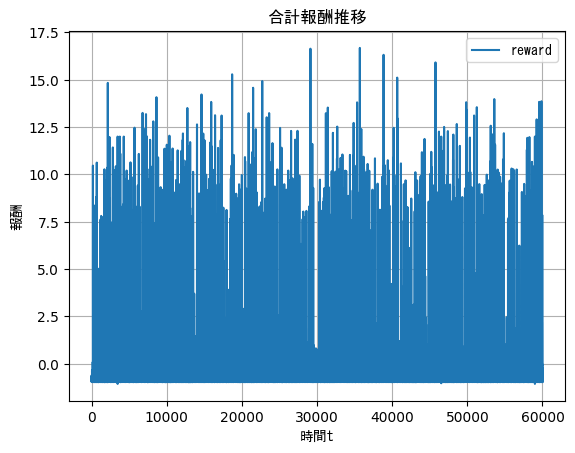

In [5]:
from tqdm import trange
import mujoco
import mujoco.viewer
# # import time
import matplotlib.pyplot as plt
MAX_STEP = 12000
NUM_EPISODE = 60000
epi_reward_graph = []
# timestep_count = []
sumreward = 0


env = MyEnv()
agt = TableQAgt()

# with mujoco.viewer.launch_passive(env.model,env.data) as viewer: #mujoco描画起動

obs = env.reset() #エピソード初期の観測を取得
for episode_num in trange(NUM_EPISODE):
    for step_num in range (MAX_STEP):
        # time.sleep(0.01)  # 1秒間停止
        act = agt.select_action(obs) #obsにより，行動を決める　Qテーブルのそのマス目を用意して，たまにイプシロングリーディでランダム動作が起きる
        rwd, done, next_obs = env.step(act)
        # viewer.sync() # mj_stepで進めたシミュレーションを，描画に反映する　　物理状態の変更を反映する
        agt.learn(obs, act, rwd, done, next_obs)
        # print(obs)####################
        obs = next_obs
        sumreward += rwd
        if done == True:
            obs = env.reset() #エピソード初期の観測を取得
            break
    epi_reward_graph.append(sumreward)
    sumreward = 0

def generate_numbered_array(length):
    return list(range(1, length+1))

# 例: 長さ指定の配列を生成
timestep_count = generate_numbered_array((episode_num+1))
plt.xlabel("時間t", fontname="MS Gothic")
plt.ylabel("報酬", fontname="MS Gothic")
plt.grid()
plt.title("合計報酬推移", fontname="MS Gothic")
plt.plot(timestep_count, epi_reward_graph, linestyle='solid', label="reward")
plt.legend(prop={'family':'MS Gothic'})
plt.show()

In [1]:
# 例: 長さ指定の配列を生成
timestep_count = generate_numbered_array((episode_num+1))
plt.xlabel("時間t", fontname="MS Gothic")
plt.ylabel("報酬", fontname="MS Gothic")
plt.grid()
plt.title("合計報酬推移", fontname="MS Gothic")
plt.plot(timestep_count, epi_reward_graph, linestyle='solid', label="reward")
plt.legend(prop={'family':'MS Gothic'})
plt.show()

NameError: name 'generate_numbered_array' is not defined

In [25]:
print(env.model.geom_pos)

[[0.    0.    0.   ]
 [0.    0.    0.001]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]]


In [3]:
import numpy as np
ob1 = 0.7
obs=np.digitize(ob1, 0.0, 0.18, 10)*1000

TypeError: digitize() takes from 2 to 3 positional arguments but 4 were given

# agt_netQ

In [3]:
# """
# agt_netQ.py
# ニューラルネット（Qネットワーク）を使ったQ学習アルゴリズム
# """
# import numpy as np
# import os
# import torch
# from torch import nn

# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import Dense, Flatten




# import mujoco

# # 自作モジュール
# # import core


AttributeError: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)

In [ ]:
# # ネットワークの定義
# class SimpleNet(nn.Module):
#     def __init__(self):
#         super(SimpleNet, self).__init__()
#         self.fc1 = nn.Linear(4, 32)  # 入力層から中間層への結合
#         self.fc2 = nn.Linear(32, 2)  # 中間層から出力層への結合

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))  # 中間層でReLUを使用
#         x = self.fc2(x)  # 出力層では活性化関数を使わない（恒等関数）
#         return x

# # ネットワークのインスタンス化
# net = SimpleNet()

# # オプティマイザの定義
# optimizer = optim.Adam(net.parameters(), lr=0.01)

# # ネットワークの構造を表示
# print(net)



SimpleNet(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
  (relu): ReLU()
)


In [ ]:
# class NetQAgt(coreAgt):
#     """ Qネットワークを使ったQ学習エージェントクラス """
#     def __init__(               # 引数とデフォルト値の設定 (A)
#             self,
#             n_act=3,            # int: 行動の種類数（ネットワークの出力数）
#             input_size=(4,),    # tuple of int: 入力サイズ
#             n_dense=32,         # int: 中間層のニューロン数
#             epsilon=0.1,        # float: 乱雑度
#             gamma=0.9,          # float: 割引率
#             filepath=None,      # str: 保存ファイル名
#             ):
#         """ 初期処理 """
#         # 引数の設定は適時編集
#         self.epsilon = epsilon
#         # ------------------------- 編集ここから

#         # アトリビュートにパラメータを保存 (B)
#         self.n_act = n_act
#         self.input_size = input_size
#         self.n_dense = n_dense
#         self.gamma = gamma
#         self.filepath = filepath

#         # アトリビュートにモデルを保存 (C)
#         self.model = self._build_Qnet()
#         # ------------------------- ここまで

#     def _build_Qnet(self):
#         """ 指定したパラメータでQネットワークを構築 """
#         # Qネットワークの構築 (A)
#         self.net = SimpleNet()
#         # オプティマイザの定義
#         self.optimizer = optim.Adam(net.parameters(), lr=0.01)
#         # 損失関数の定義
#         self.criterion = nn.CrossEntropyLoss()

#         return net

#     def select_action(self, obs):
#         """  観測に対して行動を出力 """
#     # ------------------------- 編集ここから
#     # 確率的に処理を分岐 (A)
#         if np.random.rand() < self.epsilon:
#             # ランダム行動 (B)
#             act = np.random.randint(0, self.n_act)
#         else:
#             # obsに対するQ値のリストを取得 (C)
#             Q = self.get_Q(obs)

#             # Qを最大にする行動
#             act = np.argmax(Q)
#         # ------------------------- ここまで
#         return act

#     def get_Q(self, obs):
#         """ 観測に対するQ値を出力 """
#         # ------------------------- 編集ここから
#         # 観測obsを入力し出力を得る (A)
#         Q = self.model.predict(
#             obs.reshape((1,) + self.input_size))[0, :]
#         # ------------------------- ここまで
#         return Q

#     def learn(self, obs, act, rwd, done, next_obs):
#         """ 学習 """
#         if rwd is None:
#             return
#         # ------------------------- 編集ここから

#         # obs に対するQネットワークの出力yを得る (A)
#         y = self.get_Q(obs)

#         # target にyの内容をコピーする (B)
#         target = y.copy()

#         if done is False:
#             # 最終状態でなかったら next_obsに対する next_yを得る(C)
#             next_y = self.get_Q(next_obs)

#             # Q[obs][act]のtarget_actを作成 (D)
#             target_act = rwd + self.gamma * max(next_y)
#         else:
#             # 最終状態の場合は報酬だけでtarget_actを作成 (E)
#             target_act = rwd

#         # targetのactの要素だけtarget_actにする (F)
#         target[act] = target_act

#         # obsと target のペアを与えて学習 (G)

#         # 学習のループ
#         for epoch in range(1):  # 1エポックの例
#             optimizer.zero_grad()  # 勾配をリセット
#             output = net(obs)  # フォワードパス
#             loss = self.criterion(output, target)  # 損失の計算
#             loss.backward()  # バックワードパス（勾配の計算）
#             optimizer.step()  # パラメータの更新
#         # ------------------------- ここまで
#         return 

#     # def save_weights(self, filepath=None):
#     #     """ モデルの重みデータの保存 """
#     #     # ------------------------- 編集ここから
#     #     if filepath is None:
#     #         filepath = self.filepath
#     #     self.model.save(filepath + '.h5', overwrite=True)
#     #     # ------------------------- ここまで

#     # def load_weights(self, filepath=None):
#     #     """ モデルの重みデータの読み込み """
#     #     # ------------------------- 編集ここから
#     #     if filepath is None:
#     #         filepath = self.filepath
#     #     self.model = tf.keras.models.load_model(filepath + '.h5')
#     #     # ------------------------- ここまで

    


In [ ]:

# if __name__ == '__main__':
#     # エージェントのインスタンス生成 (A)
#     agt = NetQAgt(n_act=3, input_size=(5,))

#     # 行動選択 (B)
#     obs = np.array([[1, 1, 1, 1, 1]])
#     act = agt.select_action(obs)
#     print('act', act)

#     # 学習 (C)
#     rwd = 1
#     done = False
#     next_obs = np.array([[1, 1, 1, 1, 2]])
#     agt.learn(obs, act, rwd, done, next_obs)

#     # モデル構造の表示 (D)
#     print('モデルの構造')
#     agt.model.summary()

#     # 重みパラメータの保存 (E)
#     agt.save_weights('agt_data/test')

#     # 重みパラメータの読み込み (F)
#     agt.load_weights('agt_data/test')

#     # モデルへの観測の入力 (G)
#     y = agt.model.predict(obs)
#     print('モデルの出力 y', y.reshape(-1))


In [ ]:
# from tqdm import trange
# print('mujocoで学習開始!!!')
# reward_for_graph = []

# env=MyEnv()

# agt= NetQAgt(2,4,32,0.1,0.9,)

# obs = env.reset()
# for t in range(100):
#     act = agt.select_action(obs) #たまにQ値最適の行動を選ぶ　グリーディほう
#     rwd, done, next_obs = env.step(act) 
#     reward_for_graph.append(rwd)

#     agt.learn(obs, act, rwd, done, next_obs)

#     obs = next_obs




mujocoで学習開始!!!


AttributeError: 'SimpleNet' object has no attribute 'predict'

In [ ]:
!pip uninstall tensorflow

^C


In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

AttributeError: module 'tensorflow' has no attribute 'keras'

# 離散化コード

In [ ]:
def discretize(value):
    # 0から0.18の範囲を10段階に分割
    if value == -1:
        value = 0.18
    discrete_value = int(value / 0.018)
    return min(discrete_value, 9)  # 最大値が10段階目になるように調整 9以上にならないようにしている

def discretize_values(ob1, ob2, ob3, ob4):
    # 各値を離散化
    discrete_ob1 = discretize(ob1)
    discrete_ob2 = discretize(ob2)
    discrete_ob3 = discretize(ob3)
    discrete_ob4 = discretize(ob4)
    sum = discrete_ob1*1000 + discrete_ob2*100 + discrete_ob3*10 + discrete_ob4*1

    return discrete_ob1, discrete_ob2, discrete_ob3, discrete_ob4, sum

# 例: ob1=0.05, ob2=0.10, ob3=0.15, ob4=0.18 の場合
ob1 = 0.14
ob2 = 0.10
ob3 = 0.15
ob4 = 0.18

discrete_ob1, discrete_ob2, discrete_ob3, discrete_ob4, sum = discretize_values(ob1, ob2, ob3, ob4)

print(f"Discretized Values: {discrete_ob1}, {discrete_ob2}, {discrete_ob3}, {discrete_ob4}, {sum}")